# Requirements



1.   PyTorch
2.   Pillow
3.   TensorBoard







## Installation & Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Checks Python Version
!python --version

Python 3.6.9


In [ ]:
# DONT RUN THIS AGAIN
# !pip install torch===1.5.1 torchvision===0.6.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# This cell allows us to import local modules from google drive
import sys
sys.path.append('/content/drive/Shared drives/Capstone Summer 2020/Collab Files/Scripts')

In [ ]:
# LOCAL MODULES
import dataset as D
import transforms as T

# "UNet++" Class Section Imports
import torch
import torch.nn as nn

# "Plotting" Section Imports
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

# "Training" Class Section Imports
from collections import defaultdict
import os
import copy
import time
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm 
from torch.utils.tensorboard import SummaryWriter
import logging

# "Dataset Processing" Section Imports
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms
from torch import optim
from torch.utils.data import DataLoader
import torchvision

# Displaying Masks
from PIL import Image
from torchvision.transforms import functional as FF

# Visualizing Model
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%load_ext tensorboard

# Data Processing

## Paths

In [ ]:
train_path_old = 'drive/Shared drives/Capstone Summer 2020/Data/REFUGE-Training400/'
validation_path_old ='drive/Shared drives/Capstone Summer 2020/Data/REFUGE-Validation400'

test_path = 'drive/Shared drives/Capstone Summer 2020/Data/Testing/'
train_path = 'drive/Shared drives/Capstone Summer 2020/Data/Training'
val_path ='drive/Shared drives/Capstone Summer 2020/Data/Validation'

root_path = 'drive/Shared drives/Capstone Summer 2020/Data/'

model_path = 'drive/Shared drives/Capstone Summer 2020/Models'


validation_image_path = 'drive/Shared drives/Capstone Summer 2020/Data/Validation/Images/'
validation_mask_path = 'drive/Shared drives/Capstone Summer 2020/Data/Validation/Masks/'

#--------- Tensor Board Directory ---------
logs_base_dir = 'drive/Shared drives/Capstone Summer 2020/Models/UNet++/runs'

## Transforms

In [ ]:
# preprocess the input image
def crop_image_with_percentage(img):
    wid, hei = img.size
    
    # (x1, x2) = 0%, 56.5%
    start_width_percentage = 0
    end_width_percentage = 0.56497175141
    # (y11, y2) = 17%, 75.3%
    start_height_percentage = 0.17023346303
    end_height_percentage = 0.75389105058
    
    new_pts = (round(start_width_percentage*wid), round(start_height_percentage*hei), round(end_width_percentage*wid), round(end_height_percentage*hei))
    return img.crop(new_pts)

def normalize(data):
  m = torch.mean(data)
  s = torch.std(data)
  return (data - m) / s

def fix_mask(mask):
    mask[mask == 128] = 1
    mask[mask == 255] = 2 
    return mask

class Dataset(BaseDataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'Images')
        self.masks_dir = os.path.join(root_dir, 'Masks')
        self.ids = os.listdir(self.images_dir)
        self.maskids = os.listdir(self.masks_dir)

    @classmethod
    def preprocess(cls, pil_img):
        img_nd = np.array(pil_img)
        # print(np.unique(img_nd))

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)
    
        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, idx):
        #load images and masks
        img_path = os.path.join(self.images_dir, self.ids[idx])
        mask_path = os.path.join(self.masks_dir, self.maskids[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        label = 0 if self.ids[idx][0] == 'n' else 1


        # transform
        img = img.resize((128, 128), resample = Image.NEAREST)
        img = self.preprocess(img)
        
        mask = mask.resize((128,128), resample = Image.NEAREST)
        mask = self.preprocess(mask) * 2

        img = torch.from_numpy(img).type(torch.FloatTensor)
        img = normalize(img)

        mask = torch.from_numpy(mask).long()
        
        return img, mask
    
    def __len__(self):
        return len(self.ids)

## Dataset

In [ ]:
# datasets = {x: Dataset(os.path.join(root_path, x)) for x in ['Training', 'Validation']}
# dataloaders = {x: DataLoader(datasets[x], batch_size = 5, shuffle=True, num_workers=4) for x in ['Training', 'Validation']}
# dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Validation']}

In [ ]:
batch_size = 5
dataset = Dataset(os.path.join(root_path, 'Training'))
n_train = round(len(dataset)*0.85)
n_val = len(dataset) - n_train
print(n_train,n_val)
dataset_sizes = {'Training': n_train, 'Validation': n_val}

train, val = torch.utils.data.random_split(dataset, [n_train, n_val])
dataloaders = {'Training': DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4),
               'Validation': DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=4)}

338 60


In [ ]:
datasets = {x: Dataset(os.path.join(root_path, x)) for x in ['Training', 'Validation']}

## Plotting

In [ ]:
def plot_data(data):
    phases = list(data.keys())
    metrics = list(data[phases[0]][0].keys())

    i = 0
    fig, axs = plt.subplots(1, len(metrics))
    fig.set_figheight(8)
    fig.set_figwidth(8*len(metrics))
    check_type = lambda x: list(x) if type(x) is np.ndarray() else None
    for metric in metrics:
        for phase in phases:
            if i == 1 and phase == 'Training':
                continue
            else:
                axs[i].plot([loss_func[metric] for loss_func in data[phase]], marker = '.', label=phase)
        axs[i].set_title(metric)
        axs[i].legend()
        i += 1
 
    plt.legend()
    plt.show()

def Normalize_Mask(mask, threshold = 0.5, flip = False):
    if not flip:
        return mask > threshold
    else:
        return mask < threshold

def plot_prediction(pred_img, disp_metrics = False, size = (22,10)):
    fig, axs = plt.subplots(1, 4, figsize = size)

    argmax = torch.argmax(pred_img, dim = 1).detach().cpu().numpy()[0]
    pred_img = pred_img.detach().cpu().numpy()
    pred_img = pred_img.squeeze(0)

    max_avg = 0
    max_i = 0
    titles = ['Channel 1','Channel 2','Channel 3','Argmax Channel']
    for i in range(len(pred_img)):
        amax, amin, avg, std = pred_metrics(pred_img[i], dis_metrics = disp_metrics)
        if avg > max_avg:
            max_avg = avg
            max_i = i
        axs[i].imshow(pred_img[i],cmap = 'gray')
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    if disp_metrics:
        print("-"*100)
    axs[3].imshow(decode_segmap(argmax, nc=3), cmap='gray')
    axs[3].set_title(titles[3])
    axs[3].axis('off')

    return max_i

In [ ]:
def decode_segmap(image, nc=3):
    label_colors = np.array([(0, 0, 0), (130, 130, 130), (255, 255, 255)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
        
    rgb = np.stack([r, g, b], axis=2)
    return rgb

# UNet++

## Visualize Model Class

In [ ]:
class VisModel:
    def __init__(self, model, criterion, optimizer, device, dataloaders, dataset_sizes):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.dataloaders = dataloaders
        self.dataset_sizes = dataset_sizes
        interact(self.choose_instance, instance_id=range(dataset_sizes['Training']))
            
    def choose_instance(self, instance_id):
        self.original_image = self.dataloaders['Training'][instance_id][0]
        self.mask = self.dataloaders['Training'][instance_id][1]
        
        plt.imshow(transforms.ToPILImage()(self.original_image.detach().cpu()), interpolation="bicubic")

        interact(self.filter_modules, show_all_modules=False)
        
    def filter_modules(self, show_all_modules):
        modules = []
        for name, module in self.model.named_modules():
            if not show_all_modules and '.' in name:
                continue
            modules.append((name, module))
        interact(self.select_module, module=modules)
        
    def forward_module_hook(self, module, input, output):
        if isinstance(output, tuple):
            activations = []
            for activation in output:
                print(activation.shape)
                activations.append(np.flip(activation.detach().cpu().numpy(), axis=2).squeeze())
            self.activation = np.expand_dims(np.array(activations), 0)
        else:
            self.activation = np.flip(output.detach().cpu().numpy(), axis=2)

    def backward_module_hook(self, module, input, output):
        output = output[0]
        self.gradient = np.flip(output.detach().cpu().numpy(), axis=2)

    def select_module(self, module):
        forward_hook_handle = module.register_forward_hook(self.forward_module_hook)
        backward_hook_handle = module.register_backward_hook(self.backward_module_hook)
        
        self.original_image = self.original_image.to(self.device)
        self.mask = self.mask.to(self.device)

        output = self.model(self.original_image.unsqueeze(0))
        loss = self.criterion(output, self.mask.type(torch.long))
        self.optimizer.zero_grad()
        loss.backward()

        forward_hook_handle.remove()
        backward_hook_handle.remove()
        
        print(self.activation.shape)
        C = self.activation.shape[1]
        cmaps = ['gray', "viridis", 'plasma', 'inferno', 'magma', 'cividis']
        interact(self.activation_plot, cmap=cmaps, channel=(0, C - 1), show_gradient=False, range=(1.0, 10.0))
        
    def activation_plot(self, cmap, channel, show_gradient, range):
        if show_gradient:
            image = self.gradient
        else:
            image = self.activation

        plt.figure(figsize=(12, 12))
        plt.tick_params(which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
        mean = np.mean(image[0, channel])
        std = np.std(image[0, channel])
        plt.imshow(image[0, channel], cmap=cmap, vmin=mean-std * range, vmax=mean + std * range, interpolation='nearest', origin='lower')
        plt.colorbar(shrink=0.5)
        

## Loss Function Class

In [ ]:
 def one_hot(x, num_classes):
    return F.one_hot(x, num_classes=num_classes).permute(0, 3, 1, 2).float()

def saturate_probabilities(x):
    return one_hot(torch.argmax(x, dim=1), num_classes=x.shape[1])

def dice_metric(prediction, target):
    N, C, H, W = prediction.shape
    spatial_dims = (2, 3)

    prediction = saturate_probabilities(prediction)
    target = one_hot(target.squeeze(1), C)

    overlap = torch.sum(prediction * target, dim=spatial_dims)
    total = torch.sum(target, dim=spatial_dims) + torch.sum(prediction, dim=spatial_dims)

    dice_coeffs = 2 * overlap / total 
    dice_coeffs = torch.mean(dice_coeffs, dim=0)

    return dice_coeffs

class HybridLogisticDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, prediction, target):
        N, C, W, H = prediction.size()
        spatial_dims = (2, 3)

        target = one_hot(target, C)

        overlap = torch.sum(prediction * target, dim=spatial_dims)
        total = torch.sum(target * target, dim=spatial_dims) + torch.sum(prediction * prediction, dim=spatial_dims)
        dice_coeffs = 2 * overlap / total

        # small eps to avoid blowing up if the model ever starts getting really confident and predicts a 0.0 score
        # This was happening around epoch 20 for NestedUNet
        eps = 1e-8
        logistic = torch.sum(target * (torch.log(prediction + eps) - eps), dim=spatial_dims) / (W * H)

        hybrid = -logistic - dice_coeffs + 1

        return torch.sum(torch.sum(hybrid, dim=1) / C) / N

## Model Training Class



In [ ]:
def compute_metrics(metrics, epoch_samples):
    computed_metrics = {}
    for k in metrics.keys():
        computed_metrics[k] = metrics[k] / epoch_samples
    return computed_metrics
    
def print_metrics(computed_metrics, phase):
    outputs = []
    for k in computed_metrics.keys():
        outputs.append("  {}:{}".format(k, computed_metrics[k]))
    print("  {} -> {}".format(phase.ljust(5), "|".join(outputs)))

def load_model(model_dir, filename):
    model = torch.load(os.path.join(model_dir, filename))
    return model

class Train(object):
    def __init__(self, model, optimizer, scheduler):
        # 1) used to give access to methods and properties of a parent or sibling class
        # 2) uses GPU if available
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_model(self, criterion, dataloaders, num_epochs = 25, best_loss = 1e5):
        lr_list = []
        start = time.time()
        best_model_weights = copy.deepcopy(self.model.state_dict())

        epochs_metrics = {'Training': [],'Validation': []}
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)

            epoch_start = time.time()
            # Training & Validation Phase for each epoch
            for phase in ['Training', 'Validation']:
                if phase == 'Training':
                    self.model.train() # Sets model to Training mode
                else:
                    self.model.eval()  # Sets model to Evaluate mode
                metrics = defaultdict(float)
                epoch_samples = 0

                for image, masks in dataloaders[phase]:
                    inputs, masks = image.to(self.device), masks.to(self.device)
                    # Zero the paramater gradients
                    self.optimizer.zero_grad()

                    # --FORWARD--
                    # tracks history if only in 'train'
                    with torch.set_grad_enabled(phase == 'Training'):
                        outputs = self.model(inputs)

                        loss = criterion(outputs, masks.squeeze(1).type(torch.long))
                        dice_cof = dice_metric(outputs, masks)

                        metrics['loss'] += loss.data.cpu().numpy() * masks.size(0)
                        metrics['dice'] += dice_cof.data.cpu().numpy() * masks.size(0)

                        # --BACKWARD--
                        if phase == 'Training':
                            loss.backward()
                            self.optimizer.step()
                    # Statistics
                    epoch_samples += inputs.size(0)
                
                comp_metrics = compute_metrics(metrics, epoch_samples)
                print_metrics(comp_metrics, phase)
                epochs_metrics[phase].append(comp_metrics)
                epoch_loss = metrics['loss'] / epoch_samples
                lr_list.append([param_group['lr'] for param_group in self.optimizer.param_groups])

                if phase == 'Training':
                    self.scheduler.step()

                # deep copy the best model
                if phase == 'Validation' and epoch_loss < best_loss:
                    print("  SAVING BEST MODEL: Epoch loss {:4f} < Best loss {:4f}".format(epoch_loss, best_loss))
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                
            time_epoch_elapsed = time.time() - epoch_start
            print('  {:.0f}m {:.0f}s'.format(time_epoch_elapsed // 60, time_epoch_elapsed % 60))
            print('\n')
        
        # Prints the Best Val Loss Value
        time_elapsed = time.time() - start
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best Validation Loss: {:4f}'.format(best_loss))

        # Load the best model weights
        self.model.load_state_dict(best_model_weights)

        return self.model, epochs_metrics, lr_list

### Model Prediction Function

In [ ]:
def pred_metrics(pred, dis_metrics=False):
    amax = np.amax(pred)
    amin = np.amin(pred)
    avg = np.mean(pred)
    std = np.std(pred)

    if dis_metrics is True:
        print("Max: {} | Min: {} | Avg: {} | Std: {}".format(amax,amin,avg,std))

    return amax, amin, avg, std
    

## UNet++ Class


In [ ]:
class conv_block_nested(nn.Module):
    def __init__(self, in_ch, out_ch, residual=True, dropout_prob = 0.0):
        super(conv_block_nested, self).__init__()
        self.dropout = None
        self.residual = residual
        self.out_ch = out_ch
        if self.residual:
            self.res_conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        if dropout_prob != 0.0:
            self.dropout = nn.Dropout2d(p=dropout_prob)
        
        self.activation = nn.ReLU(inplace=True)
        # self.activation = nn.LeakyReLU(negative_slope = 0.01, inplace=True)
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        if self.residual:
            x_res = self.res_conv(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)

        if self.residual:
            x = x_res + x

        if self.dropout is not None:
            x = self.dropout(x)
        return x

class Nested_UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, layers=64, dropout_p = 0.0):
        super(Nested_UNet, self).__init__()
        filters = [layers, layers * 2, layers * 4, layers * 8, layers * 16]

        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool = nn.AvgPool2d(kernel_size=2,stride=2,count_include_pad=False)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], residual=True, dropout_prob=dropout_p)
        self.conv1_0 = conv_block_nested(filters[0], filters[1], dropout_p)
        self.conv2_0 = conv_block_nested(filters[1], filters[2], dropout_p)
        self.conv3_0 = conv_block_nested(filters[2], filters[3], dropout_p)
        self.conv4_0 = conv_block_nested(filters[3], filters[4], dropout_p)

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], residual=True, dropout_prob=dropout_p)
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], dropout_p)
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], dropout_p)
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], dropout_p)

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], residual=True, dropout_prob=dropout_p)
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], dropout_p)
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], dropout_p)

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], residual=True, dropout_prob=dropout_p)
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], dropout_p)

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], residual = True, dropout_prob=dropout_p)

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=3, padding=1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        output = F.softmax(output, dim=1)

        return output

### **Model Training**


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0xDEADBEEF)
model = Nested_UNet(in_ch = 3, out_ch = 3, dropout_p=0.10)
model.to(device)

# weights for Cross Entropy Loss Function
cls_weights = [1.0, 1.0, 1.0]
cls_weights = torch.FloatTensor(cls_weights).to(device)

# criterion = nn.CrossEntropyLoss(weight = cls_weights)
criterion = HybridLogisticDiceLoss()
optimizer_func = optim.Adam(model.parameters(), lr = 0.000025)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_func, step_size = 1000, gamma = 0.1)

trainer = Train(model, optimizer = optimizer_func, scheduler = lr_scheduler)
model, metrics, learning_rate = trainer.train_model(criterion, dataloaders, num_epochs = 15)

Epoch 1/15
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)


  Training ->   loss:0.46791447355197024|  dice:[0.4216909  0.48838493 0.9237567 ]
  Validation ->   loss:0.41717159003019333|  dice:[0.5127606  0.49873537 0.93922055]
  SAVING BEST MODEL: Epoch loss 0.417172 < Best loss 100000.000000
  0m 29s


Epoch 2/15
----------
  Training ->   loss:0.380963145099448|  dice:[0.5220573 0.5520303 0.9428248]
  Validation ->   loss:0.42029551168282825|  dice:[0.38562185 0.55212426 0.9463606 ]
  0m 30s


Epoch 3/15
----------
  Training ->   loss:0.3635696688523659|  dice:[0.55400854 0.5688584  0.94583493]
  Validation ->   loss:0.37323905030886334|  dice:[0.53925705 0.57110083 0.9387221 ]
  SAVING BEST MODEL: Epoch loss 0.373239 < Best loss 0.417172
  0m 29s


Epoch 4/15
----------
  Training ->   loss:0.3502272536768716|  dice:[0.5628461  0.5825638  0.94685745]
  Validation ->   loss:0.39055342972278595|  dice:[0.5320005  0.54238427 0.93520385]
  0m 29s


Epoch 5/15
----------
  Training ->   loss:0.33863857088709726|  dice:[0.57851183 0.5891798  0.9

#### Model Metrics
--- 
#### **Model Parameters:**
---


In [ ]:
# # # Saves the model as a .pt file
# torch.save(model, os.path.join(model_path, 'UNet++_3ch_HLDL_25EPOCH3.pt'))

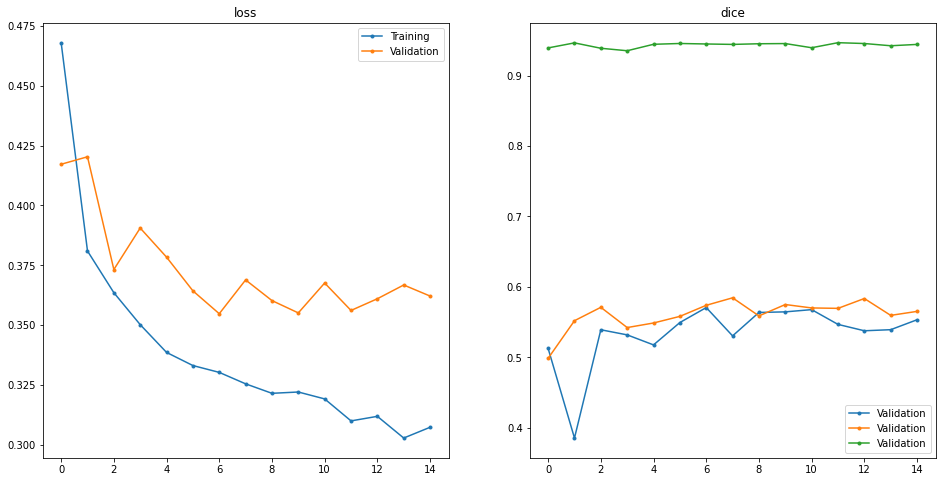

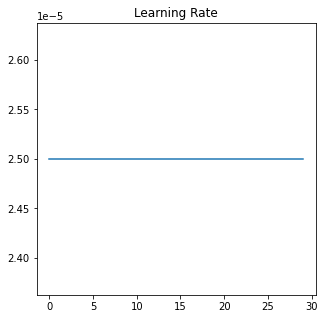

In [ ]:
# %tensorboard --logdir 'drive/Shared drives/Capstone Summer 2020/Models/UNet++'
# plt.figure(figsize=(10,10))
plot_data(metrics)

plt.figure(figsize=(5,5))
plt.plot([i[0] for i in learning_rate])
plt.title('Learning Rate')
plt.show()

In [ ]:
# model = load_model(model_path,'UNet++_3ch_HLDL_25EPOCH3.pt')

In [ ]:
VisModel(model, criterion, optimizer_func, device, datasets, dataset_sizes)

interactive(children=(Dropdown(description='instance_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

#### Model Prediction Cropped (out_ch: 3)

In [ ]:
def decode_segmap(image, nc=3):
  
  label_colors = np.array([(0, 0, 0), (130, 130, 130), (255, 255, 255)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

Max: 0.36747434735298157 | Min: 0.2538602352142334 | Avg: 0.31076884269714355 | Std: 0.009132405743002892
Max: 0.42764613032341003 | Min: 0.26151132583618164 | Avg: 0.3297847509384155 | Std: 0.02778838761150837
Max: 0.44317078590393066 | Min: 0.22577697038650513 | Avg: 0.3594464063644409 | Std: 0.03197609633207321
----------------------------------------------------------------------------------------------------
Max: 0.3927060067653656 | Min: 0.26420000195503235 | Avg: 0.31596672534942627 | Std: 0.013310187496244907
Max: 0.42016589641571045 | Min: 0.2582853436470032 | Avg: 0.33024144172668457 | Std: 0.028014836832880974
Max: 0.44647061824798584 | Min: 0.23386606574058533 | Avg: 0.35379183292388916 | Std: 0.02974100597202778
----------------------------------------------------------------------------------------------------
Max: 0.4046609103679657 | Min: 0.2708509862422943 | Avg: 0.31560224294662476 | Std: 0.011427035555243492
Max: 0.41611769795417786 | Min: 0.2685719132423401 | Avg: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[None, None, None]

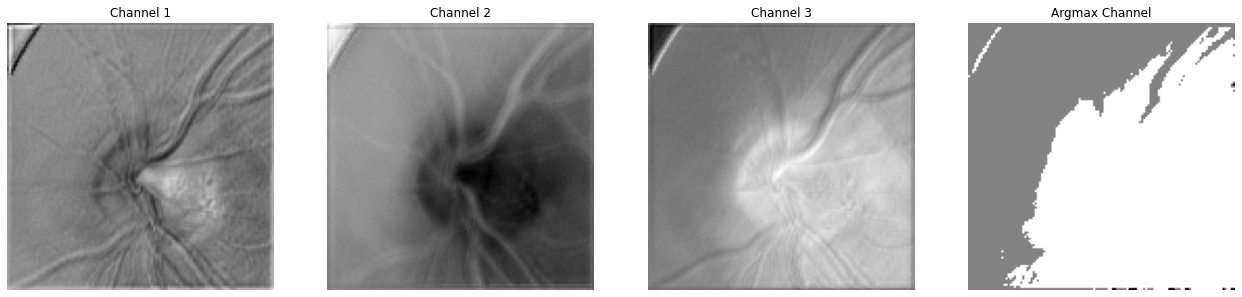

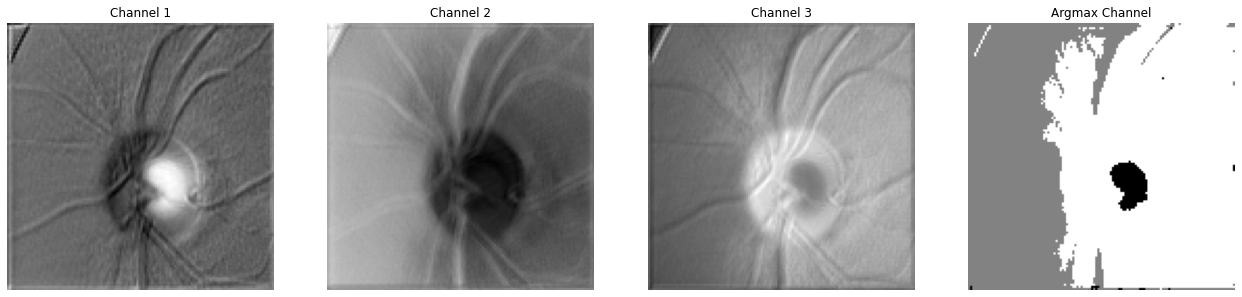

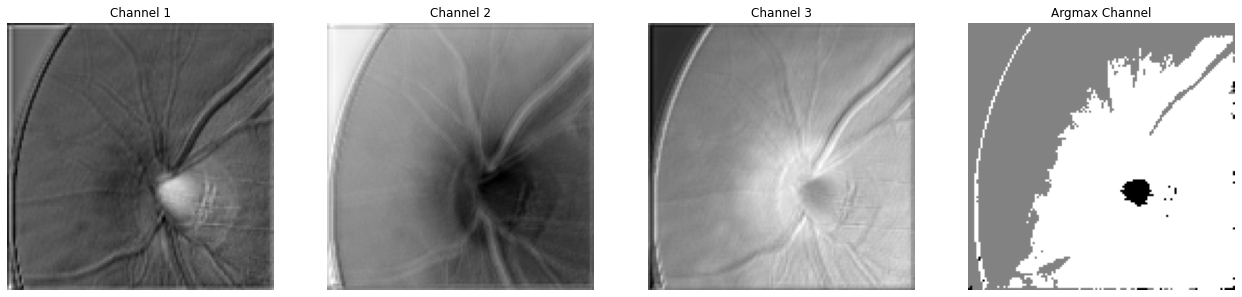

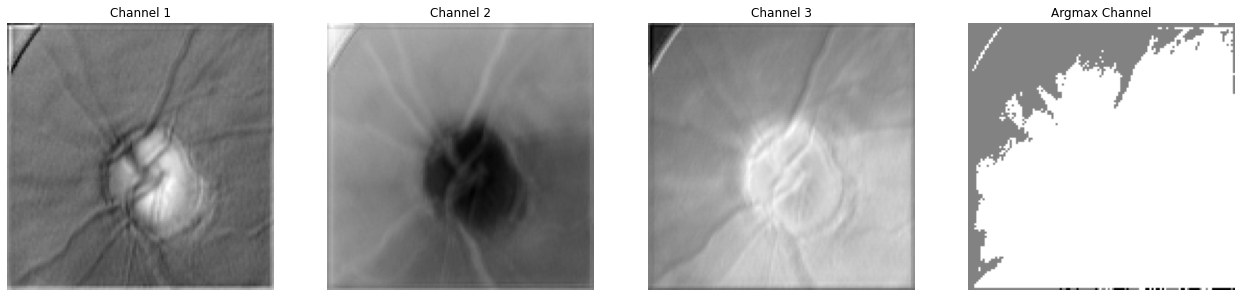

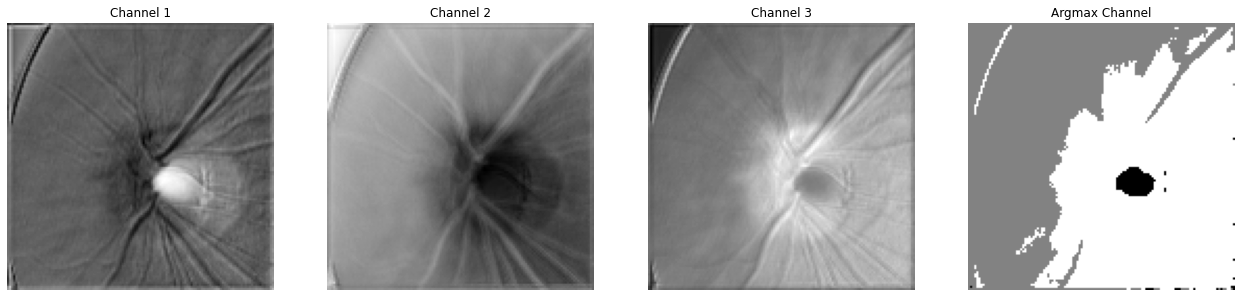

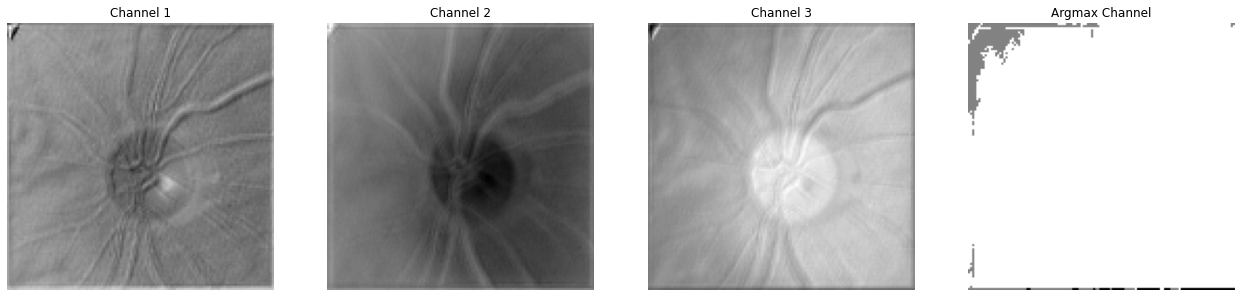

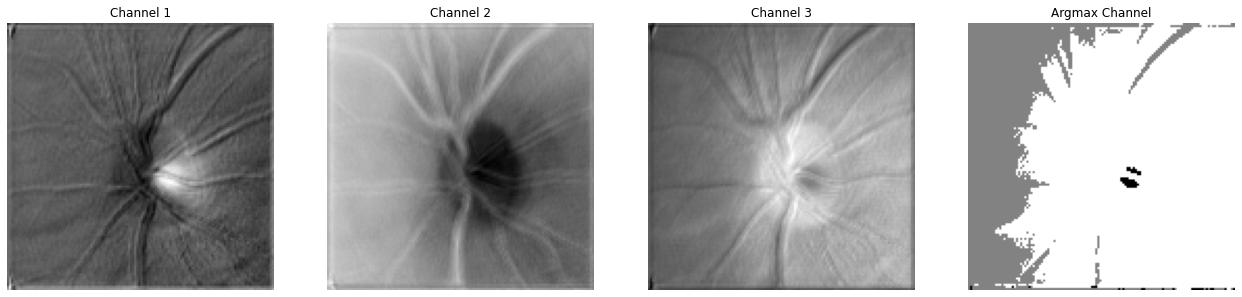

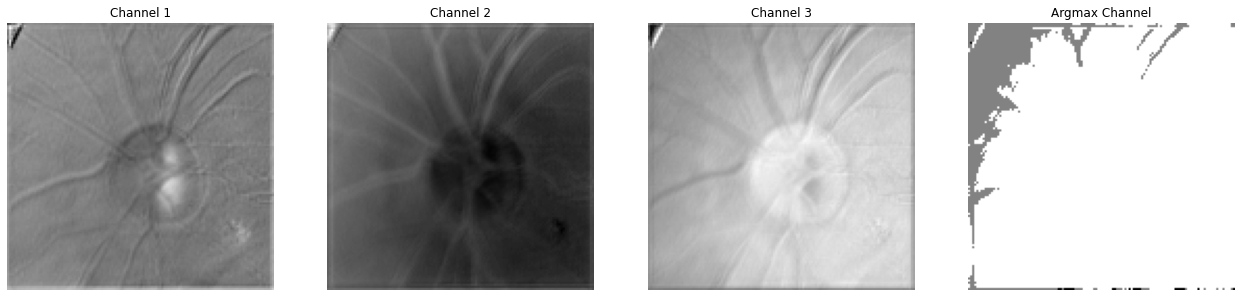

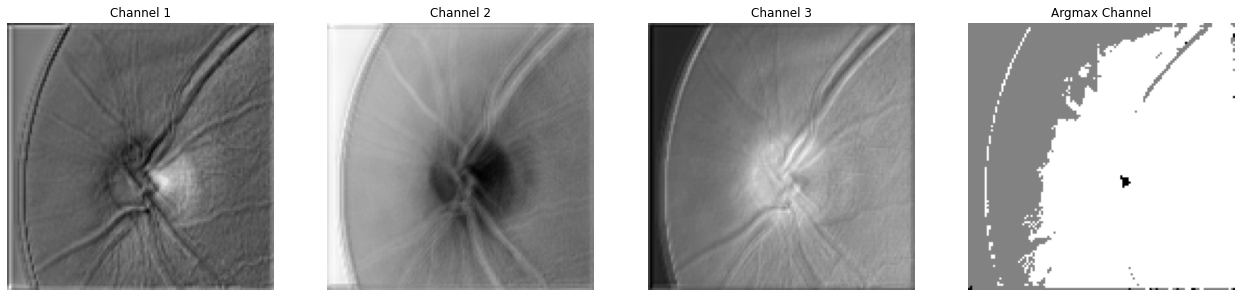

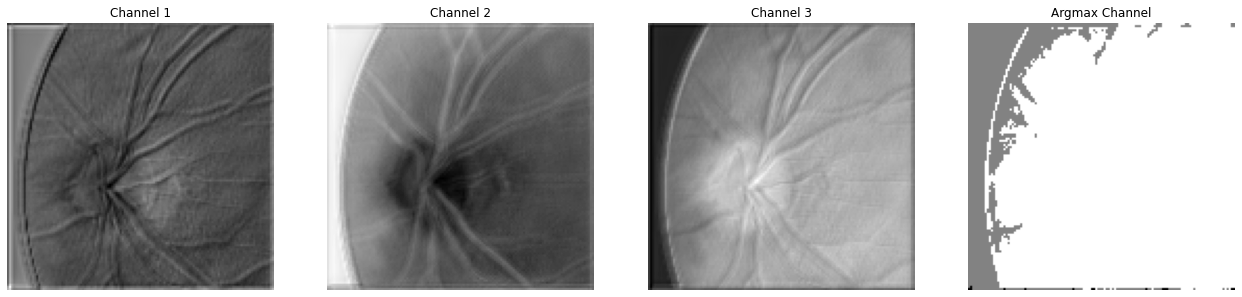

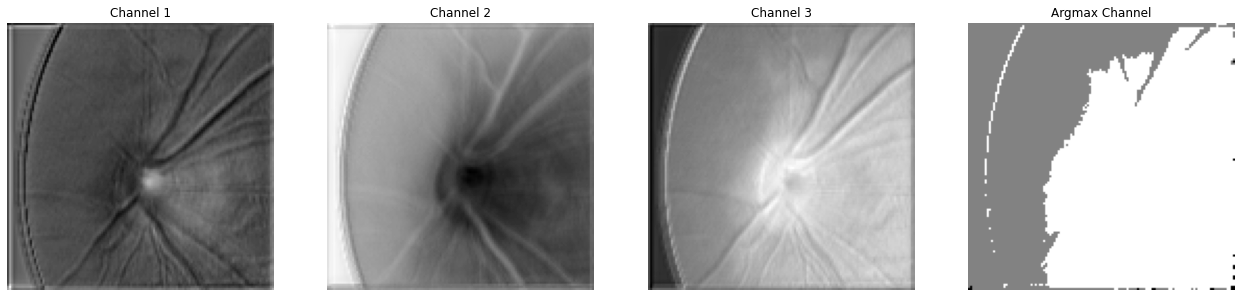

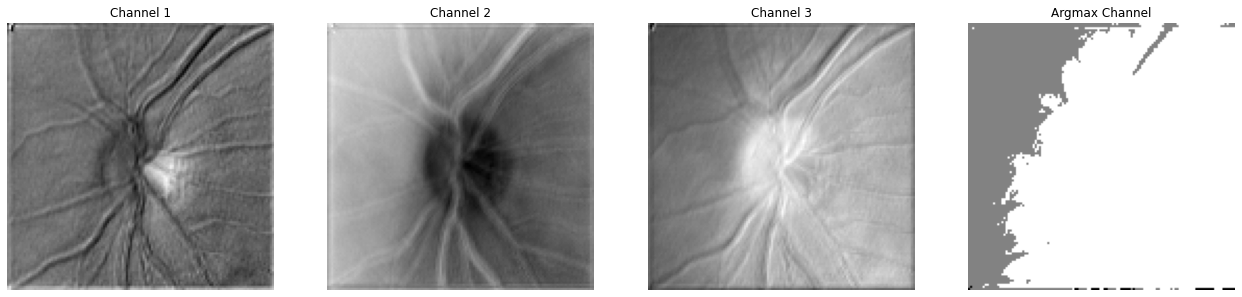

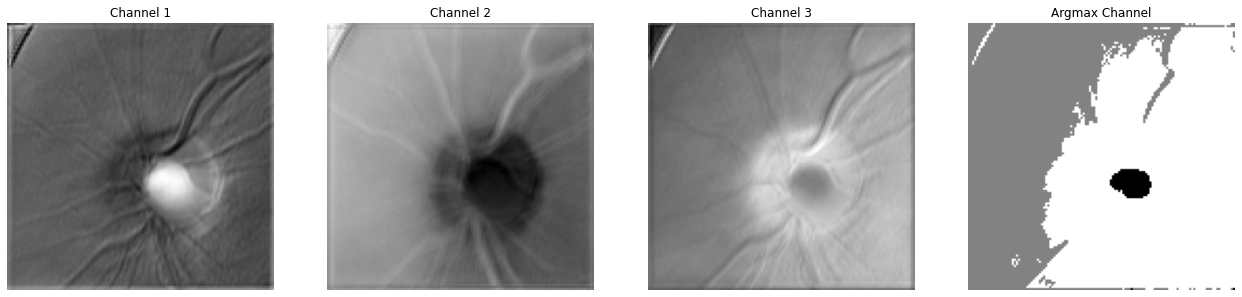

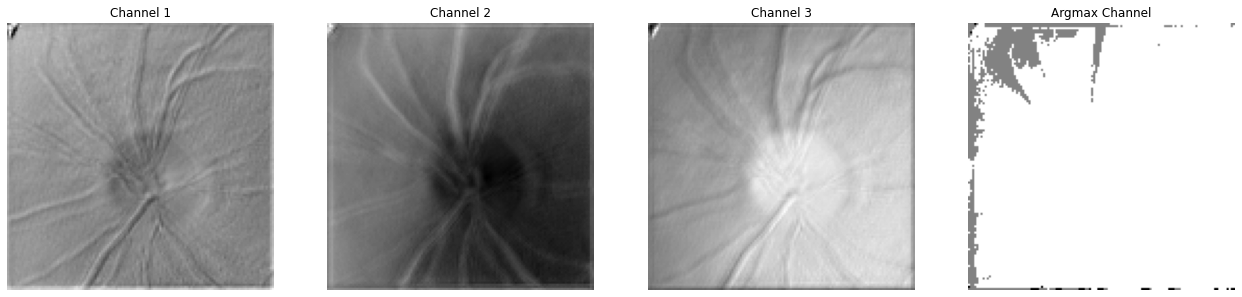

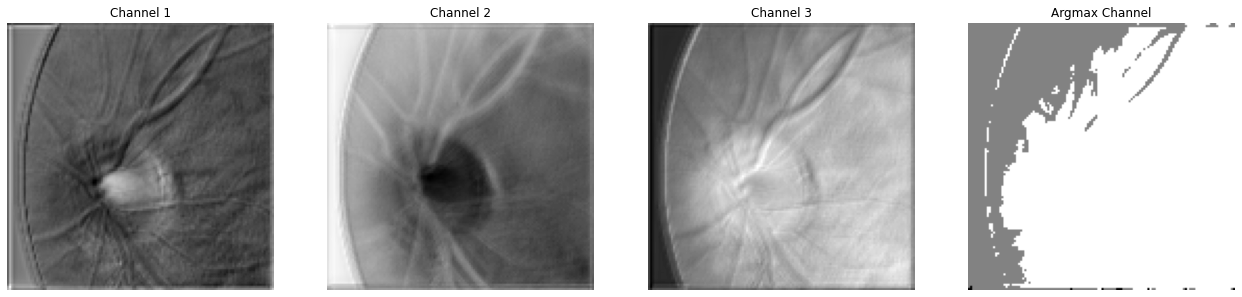

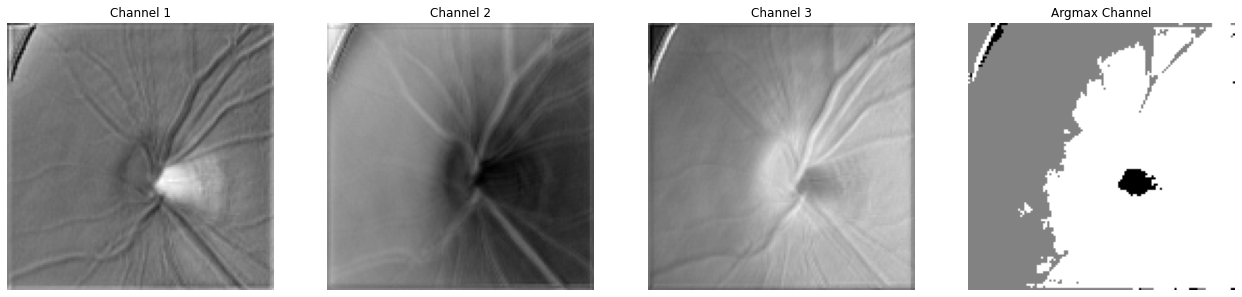

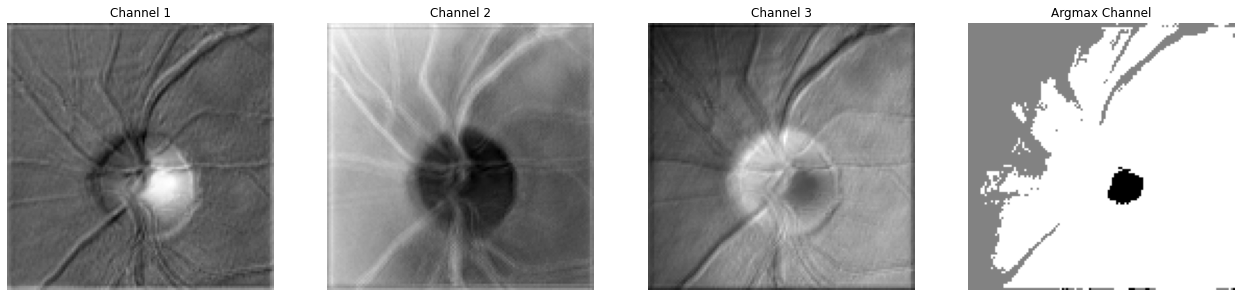

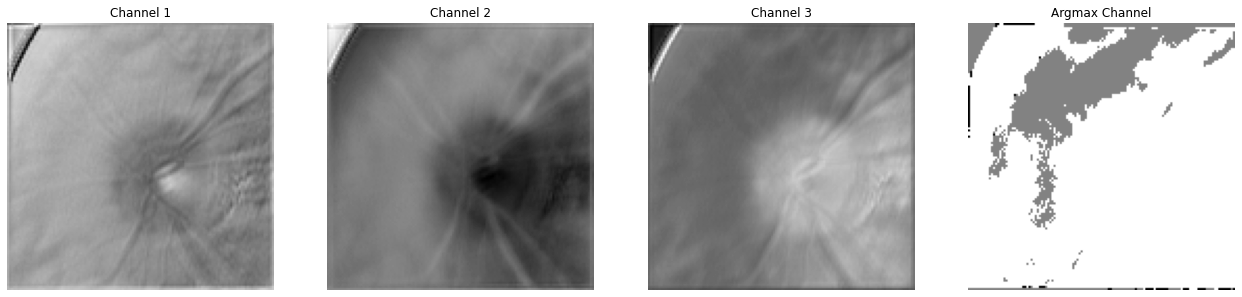

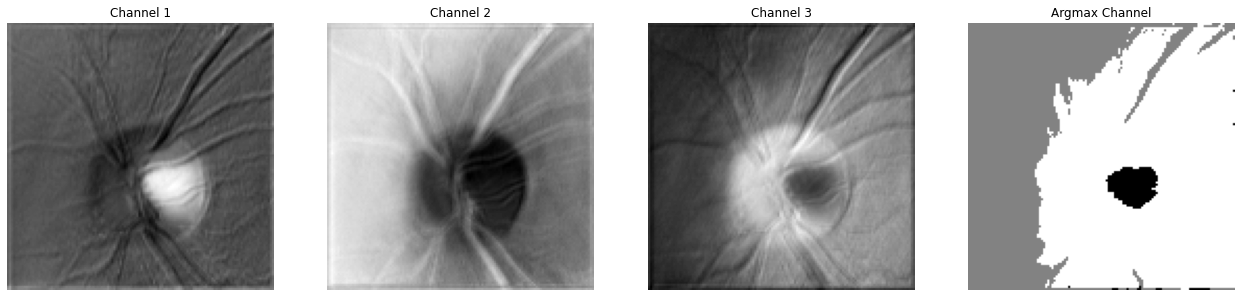

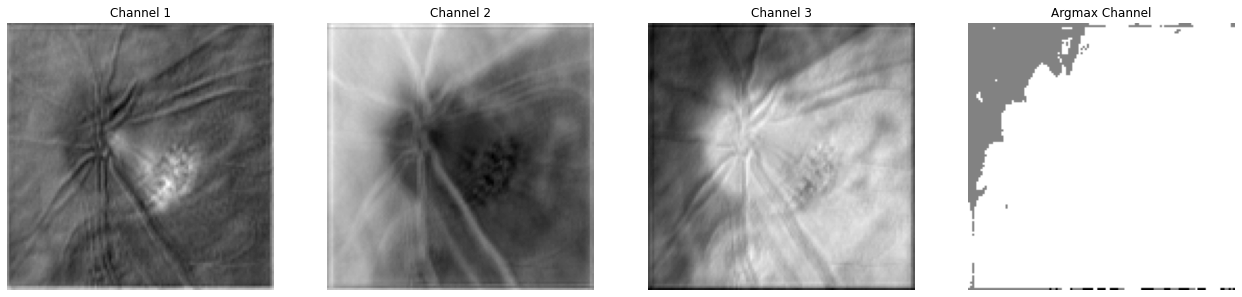

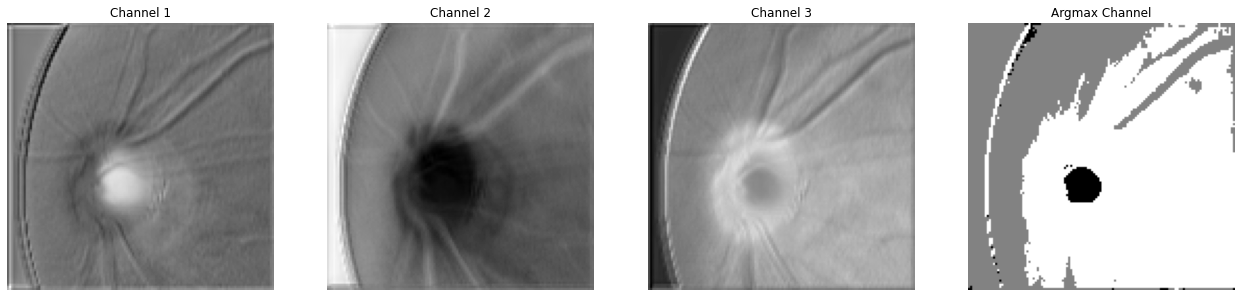

In [ ]:
folder = 'Validation'
img_dir = "drive/Shared drives/Capstone Summer 2020/Data/"+ folder +"/Images/"
msk_dir = "drive/Shared drives/Capstone Summer 2020/Data/"+ folder +"/Masks/"

ext = ['.jpg','.bmp']
max_indices_list = [] 
for i in range(380,401):
    img_name = "V" + str(i).zfill(4)
    if not os.path.exists(img_dir + img_name + ext[0]):
        continue
    else:
        img_path = img_dir + img_name + ext[0]
        msk_path = msk_dir + img_name + ext[1]
        #------------------------------------------------------------------------------
        img = Image.open(img_path).convert("RGB").resize((128,128), resample = Image.NEAREST)
        img = torch.from_numpy(Dataset.preprocess(img))
        img = img.to(device)
        img = img.type(torch.cuda.FloatTensor)
        img = img.unsqueeze(0)
        img = normalize(img)
        #------------------------------------------------------------------------------
        mask = Image.open(msk_path).convert('L')
        mask = mask.resize((128,128), resample = Image.NEAREST)
        mask = np.array(mask)
        mask = np.expand_dims(mask, axis = 0)
        mask = torch.from_numpy(mask)
        mask = fix_mask(mask)
        #------------------------------------------------------------------------------
        result = model(img)
        ind = plot_prediction(result, disp_metrics=True)
        max_indices_list.append(ind)
[print("Max Avg Counts in Channel {}: {}".format(i + 1,max_indices_list.count(i))) for i in range(3)]